In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.metrics import confusion_matrix,classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [4]:
# !pip install ydata-profiling

In [5]:
# from ydata_profiling import ProfileReport

In [6]:
train_df = pd.read_csv('Train_set_(1)_(1).csv')

In [7]:
# profile = ProfileReport(train_df, title="Profiling Report")

In [8]:
# profile.to_file("report.html")  # Save as an HTML file

In [9]:
# profile

In [10]:
test_df = pd.read_csv('Test_set_(1)_(2).csv')
test_df.head(1)

,ID,loan_amnt,loan_term,interest_rate,loan_grade,loan_subgrade,job_experience,home_ownership,annual_income,income_verification_status,...,debt_to_income,delinq_2yrs,public_records,revolving_balance,total_acc,interest_receive,application_type,last_week_pay,total_current_balance,total_revolving_limit
0,4855329,12000,3 years,15.31,C,C2,<5 Years,MORTGAGE,73400.0,Not Verified,...,14.62,0.0,0.0,22156,30.0,2290.24,INDIVIDUAL,87.0,128098.0,25800.0


## Relation with default

In [11]:
train_df['delq_factor'] = train_df['delinq_2yrs']/ train_df['total_acc']
test_df['delq_factor'] = test_df['delinq_2yrs']/ test_df['total_acc']

In [12]:
# train_df['avg_balance'] = train_df['total_current_balance']/ train_df['total_acc']

In [13]:
train_df['used_credit'] = train_df['total_revolving_limit'] - train_df['revolving_balance']
train_df['interest_fraction'] = train_df['interest_receive']/ train_df['loan_amnt']
#train_df['emi_fraction'] = train_df['last_week_pay']/ train_df['loan_amnt']

In [14]:
test_df['used_credit'] = test_df['total_revolving_limit'] - test_df['revolving_balance']
test_df['interest_fraction'] = test_df['interest_receive']/ test_df['loan_amnt']

In [15]:
train_df['tenure'] = train_df['loan_term'].apply(lambda x:int(x.split(' years')[0]))
train_df['emi_fraction'] = train_df['last_week_pay']/(train_df['tenure']*12)
# train_df.drop(columns='tenure',inplace = True)

In [16]:
test_df['tenure'] = test_df['loan_term'].apply(lambda x:int(x.split(' years')[0]))
test_df['emi_fraction'] = test_df['last_week_pay']/(test_df['tenure']*12)

In [17]:
train_df['tenure']

0        3
1        3
2        3
3        3
4        3
        ..
93169    3
93170    3
93171    3
93172    3
93173    3
Name: tenure, Length: 93174, dtype: int64

In [18]:
train_df['emi_fraction']

0        0.111111
1        2.638889
2        0.361111
3        0.472222
4        1.083333
           ...   
93169    0.361111
93170    4.472222
93171    1.805556
93172    1.555556
93173    2.888889
Name: emi_fraction, Length: 93174, dtype: float64

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93174 entries, 0 to 93173
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          93174 non-null  int64  
 1   loan_amnt                   93174 non-null  int64  
 2   loan_term                   93174 non-null  object 
 3   interest_rate               93174 non-null  float64
 4   loan_grade                  93174 non-null  object 
 5   loan_subgrade               93174 non-null  object 
 6   job_experience              88472 non-null  object 
 7   home_ownership              93174 non-null  object 
 8   annual_income               93173 non-null  float64
 9   income_verification_status  93174 non-null  object 
 10  loan_purpose                93174 non-null  object 
 11  state_code                  93174 non-null  object 
 12  debt_to_income              93174 non-null  float64
 13  delinq_2yrs                 931

In [20]:
cat_cols = [cols for cols in train_df.columns if train_df[cols].dtype == 'object']
id_cols = [cols for cols in train_df.columns if 'ID' in cols.upper()]
num_cols = [cols for cols in train_df.columns if train_df[cols].dtype != 'object' and cols not in id_cols and cols!= 'default']

In [21]:
# splitting columns into categorical and numeric
cat_cols = train_df.select_dtypes(include = ['object']).columns.to_list()
num_cols = [col for col in train_df.columns if col not in cat_cols and col not in ('default','ID')]
print(len(cat_cols))
print(cat_cols)

print(len(num_cols))
print(num_cols)

9
['loan_term', 'loan_grade', 'loan_subgrade', 'job_experience', 'home_ownership', 'income_verification_status', 'loan_purpose', 'state_code', 'application_type']
17
['loan_amnt', 'interest_rate', 'annual_income', 'debt_to_income', 'delinq_2yrs', 'public_records', 'revolving_balance', 'total_acc', 'interest_receive', 'last_week_pay', 'total_current_balance', 'total_revolving_limit', 'delq_factor', 'used_credit', 'interest_fraction', 'tenure', 'emi_fraction']


# Create a subset of train for quick iterations

In [22]:
print(train_df['default'].mean())
subset = train_df.sample(frac = 0.5)
print(subset['default'].mean())

0.2375018782063666
0.2363964196020349


In [23]:
# subset.to_csv('subset_train.csv',index = False)

In [24]:
# crosstab function
def cross_tab(df,feat):
  cross_df = pd.crosstab(df[feat],df['default'],normalize = 'index').sort_values(by = 1,ascending = False)
  print(cross_df)
  print('--'*30)
  cross_df.plot(kind = 'bar')
  plt.show()

# Cross Tab with Categorical Columns for EDA

default           0         1
loan_term                    
3 years    0.727220  0.272780
5 years    0.848735  0.151265
------------------------------------------------------------


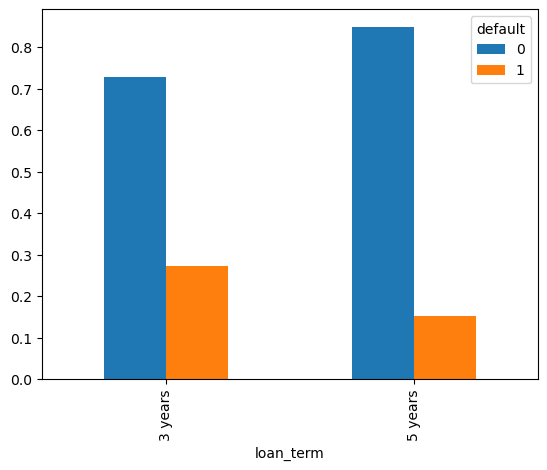

************************************************************
default            0         1
loan_grade                    
A           0.725551  0.274449
B           0.736129  0.263871
D           0.782250  0.217750
C           0.787284  0.212716
G           0.791971  0.208029
F           0.796075  0.203925
E           0.812246  0.187754
------------------------------------------------------------


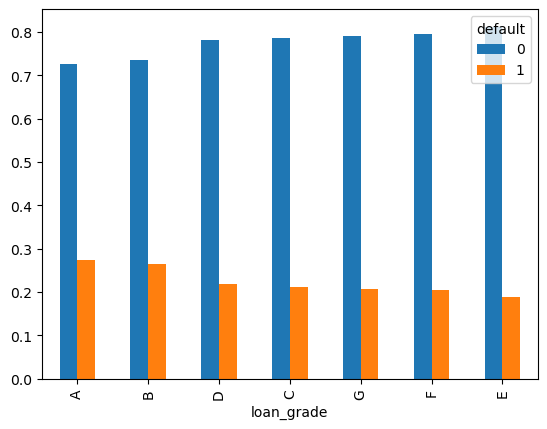

************************************************************
default               0         1
loan_subgrade                    
A4             0.695991  0.304009
A3             0.700242  0.299758
B3             0.713079  0.286921
A2             0.717282  0.282718
B2             0.727860  0.272140
B4             0.738425  0.261575
A1             0.747710  0.252290
G4             0.750000  0.250000
B5             0.751196  0.248804
A5             0.754612  0.245388
B1             0.754709  0.245291
E5             0.764706  0.235294
G3             0.766667  0.233333
C1             0.767001  0.232999
D3             0.770107  0.229893
D2             0.773795  0.226205
F4             0.777778  0.222222
C2             0.782070  0.217930
D1             0.783333  0.216667
F3             0.786667  0.213333
C3             0.788433  0.211567
E3             0.789189  0.210811
D5             0.790535  0.209465
G1             0.792208  0.207792
F2             0.793919  0.206081
D4             0.7962

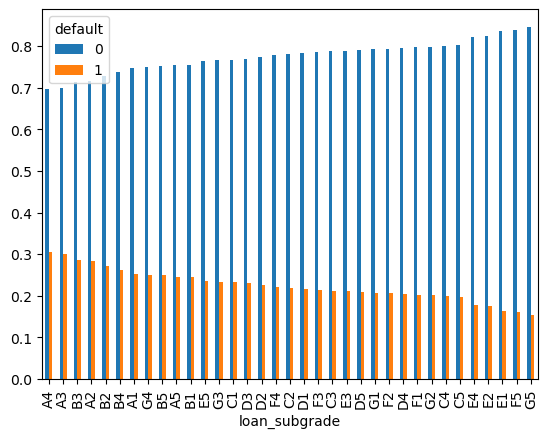

************************************************************
default                0         1
job_experience                    
6-10 years      0.749915  0.250085
<5 Years        0.750754  0.249246
10+ years       0.777022  0.222978
------------------------------------------------------------


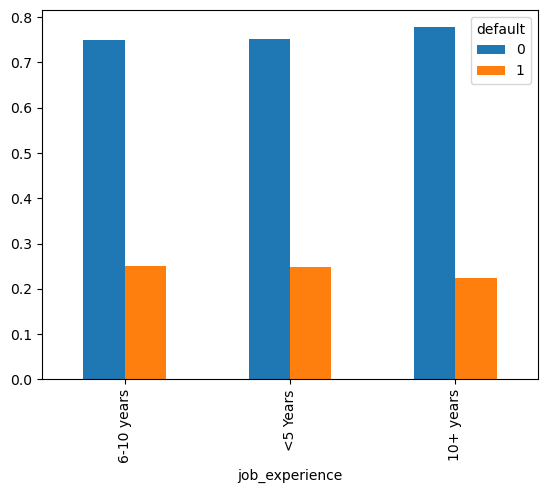

************************************************************
default                0         1
home_ownership                    
OTHER           0.181818  0.818182
NONE            0.333333  0.666667
MORTGAGE        0.757770  0.242230
RENT            0.764096  0.235904
OWN             0.792481  0.207519
------------------------------------------------------------


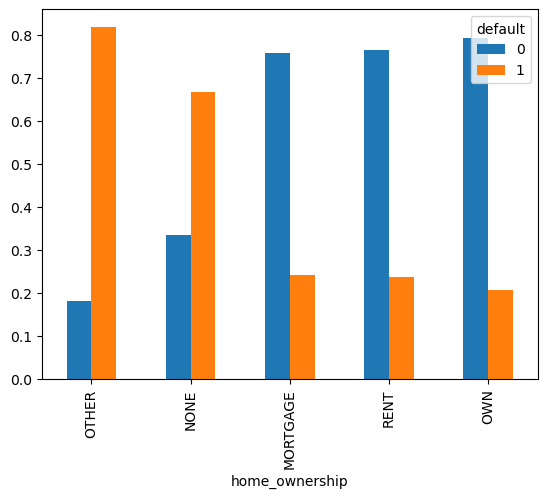

************************************************************
default                            0         1
income_verification_status                    
Not Verified                0.717866  0.282134
Verified                    0.746729  0.253271
Source Verified             0.815241  0.184759
------------------------------------------------------------


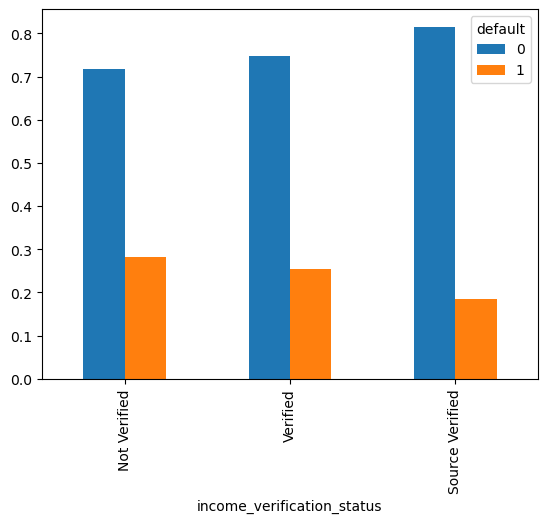

************************************************************
default                    0         1
loan_purpose                          
other               0.698293  0.301707
home_improvement    0.755703  0.244297
debt_consolidation  0.768241  0.231759
credit_card         0.786631  0.213369
------------------------------------------------------------


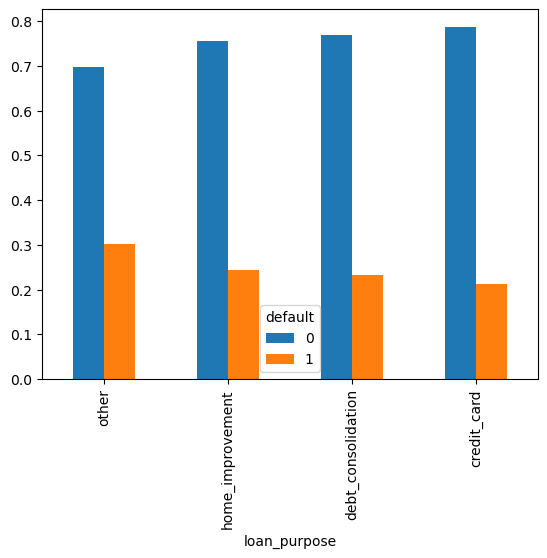

************************************************************
default            0         1
state_code                    
ID          0.000000  1.000000
DC          0.662338  0.337662
UT          0.697531  0.302469
AK          0.714286  0.285714
CA          0.721154  0.278846
VT          0.723684  0.276316
CO          0.724426  0.275574
SD          0.729167  0.270833
OR          0.730275  0.269725
NH          0.736842  0.263158
HI          0.745614  0.254386
MA          0.745961  0.254039
MD          0.746528  0.253472
WA          0.754826  0.245174
NY          0.755001  0.244999
AZ          0.755198  0.244802
NV          0.756598  0.243402
WI          0.761290  0.238710
KY          0.762637  0.237363
AR          0.765193  0.234807
LA          0.765625  0.234375
VA          0.765714  0.234286
MO          0.765766  0.234234
NC          0.770553  0.229447
WV          0.771028  0.228972
RI          0.772727  0.227273
TX          0.772849  0.227151
FL          0.773138  0.226862
MN       

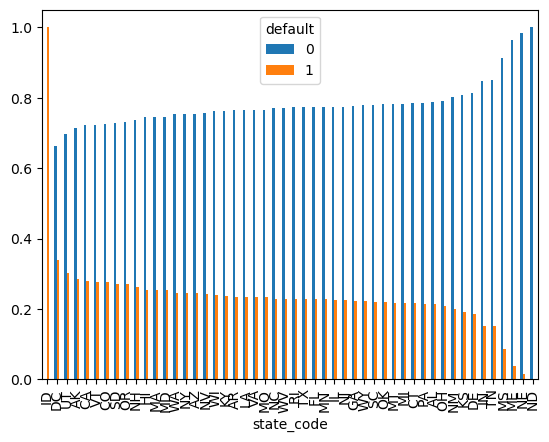

************************************************************
default                  0         1
application_type                    
INDIVIDUAL        0.763466  0.236534
JOINT             1.000000  0.000000
------------------------------------------------------------


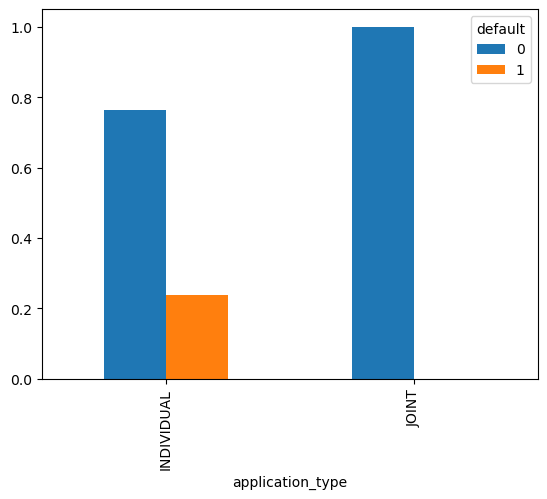

************************************************************


In [25]:
for col in cat_cols:
  cross_tab(subset,col)
  print('**'*30)

# EDA of numerical variables

In [26]:
def create_boxplot(ddf,feat):
  df = ddf.copy()
  df['default'] = df['default'].apply(str)
  sns.boxplot(y = 'default', x = feat,data = df)
  plt.show()

In [27]:
for col in num_cols:
  print(col)
  med_0 = np.median(subset[subset['default']==0][col])
  med_1 = np.median(subset[subset['default']==1][col])
  print('median_0 =',med_0)
  print('median_1 =',med_1)
  print('--'*30)

loan_amnt
median_0 = 14000.0
median_1 = 12000.0
------------------------------------------------------------
interest_rate
median_0 = 12.99
median_1 = 13.05
------------------------------------------------------------
annual_income


median_0 = 64000.0
median_1 = 65000.0
------------------------------------------------------------
debt_to_income
median_0 = 18.31
median_1 = 15.8
------------------------------------------------------------
delinq_2yrs
median_0 = 0.0
median_1 = 0.0
------------------------------------------------------------
public_records
median_0 = 0.0
median_1 = 0.0
------------------------------------------------------------
revolving_balance
median_0 = 12142.5
median_1 = 10913.0
------------------------------------------------------------
total_acc
median_0 = 24.0
median_1 = 23.0
------------------------------------------------------------
interest_receive
median_0 = 994.3
median_1 = 1295.62
------------------------------------------------------------
last_week_pay
median_0 = nan
median_1 = 69.0
------------------------------------------------------------
total_current_balance
median_0 = nan
median_1 = nan
------------------------------------------------------------
total_revolving_limit
median_0

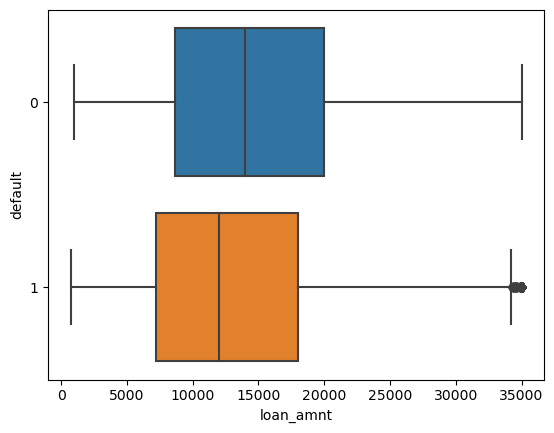

******************************************************************************************


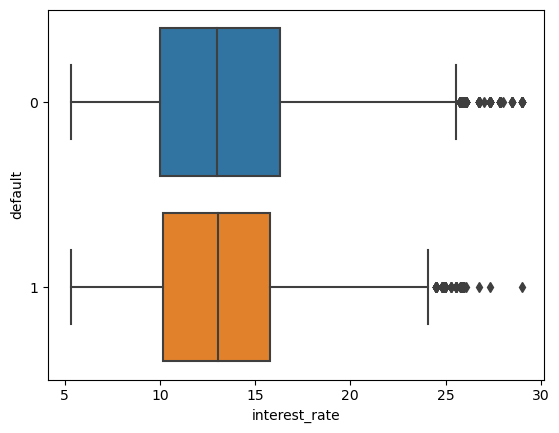

******************************************************************************************


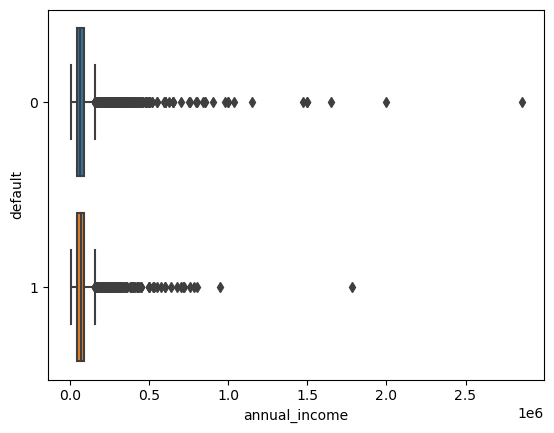

******************************************************************************************


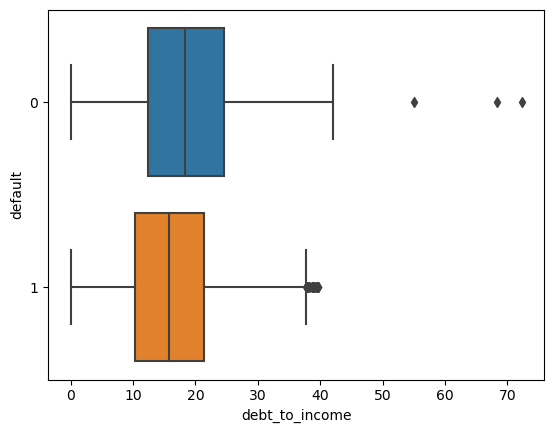

******************************************************************************************


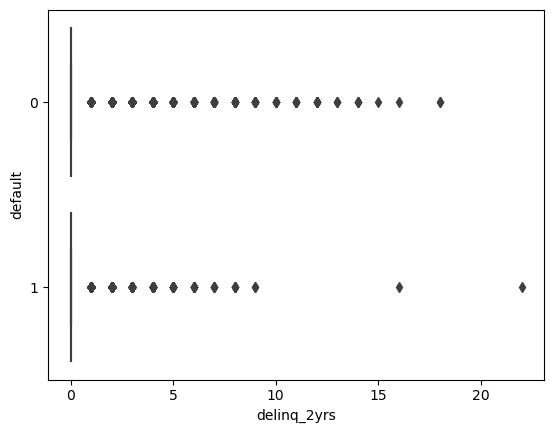

******************************************************************************************


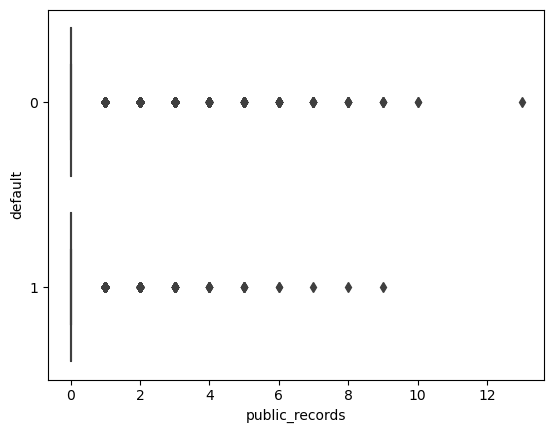

******************************************************************************************


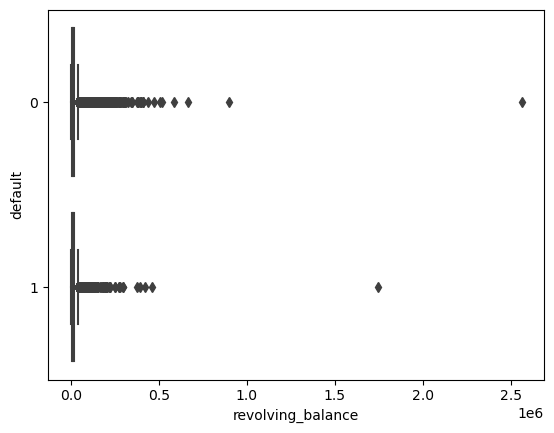

******************************************************************************************


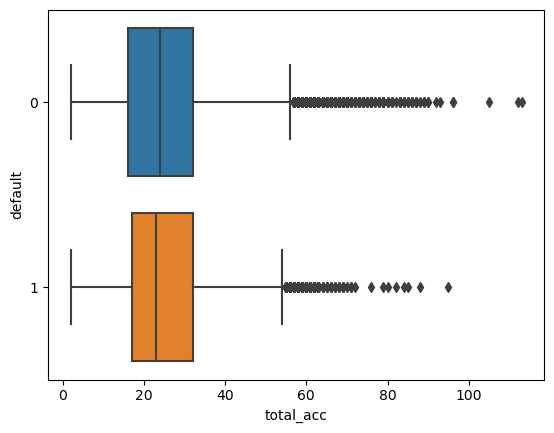

******************************************************************************************


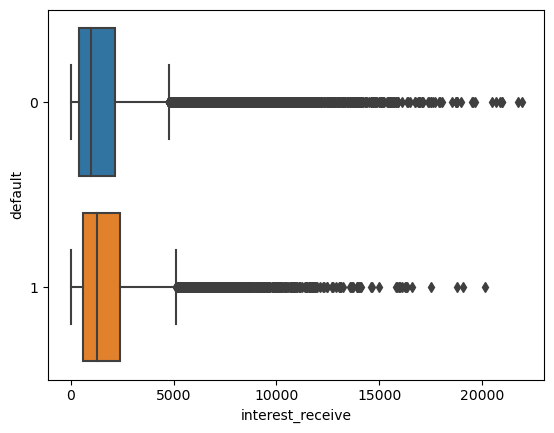

******************************************************************************************


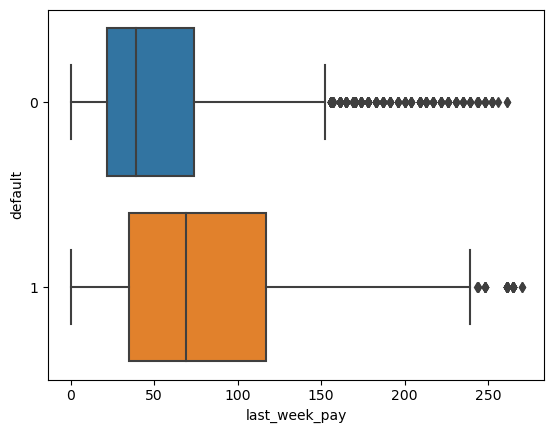

******************************************************************************************


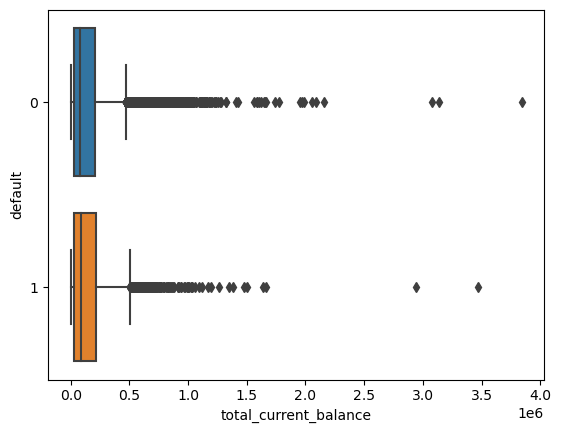

******************************************************************************************


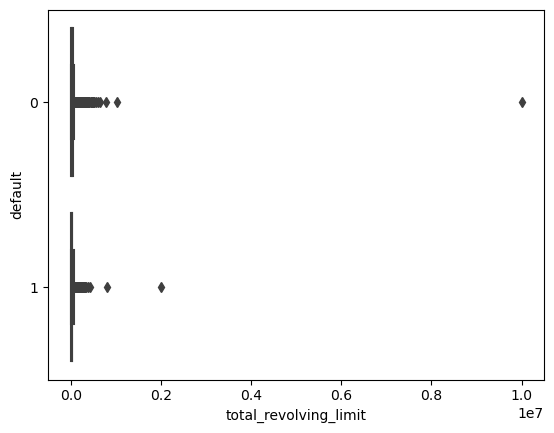

******************************************************************************************


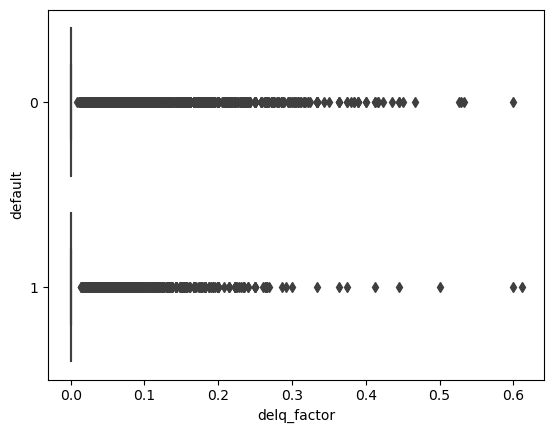

******************************************************************************************


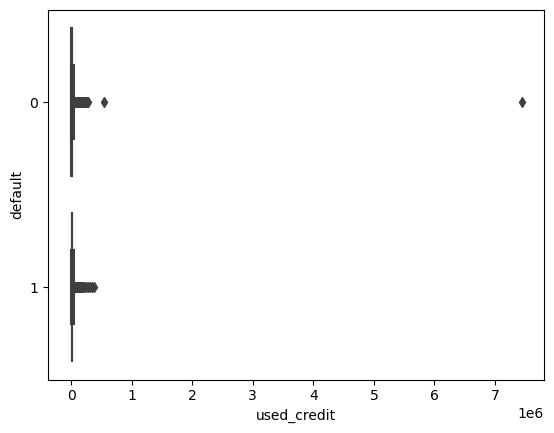

******************************************************************************************


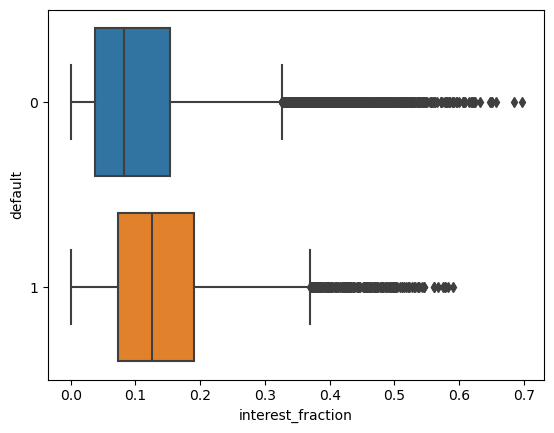

******************************************************************************************


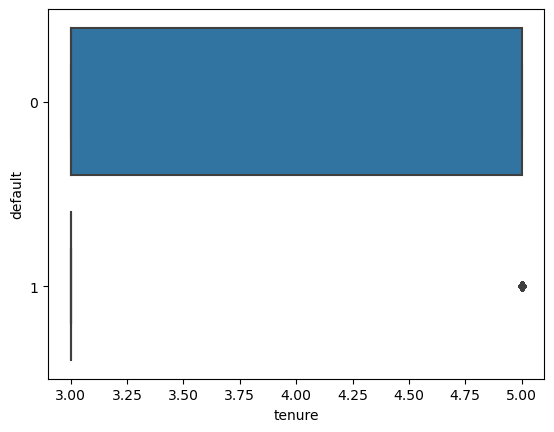

******************************************************************************************


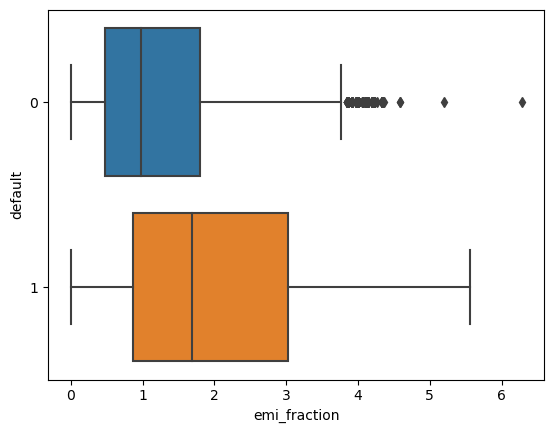

******************************************************************************************


In [28]:
for col in num_cols:
  create_boxplot(subset,col)
  print('***'*30)

# Encoding of Categorical Variables

# Deeper Analysis of loan subgrade

In [29]:
df1 = pd.DataFrame(train_df['loan_subgrade'].value_counts())
df2 = pd.DataFrame(train_df.groupby('loan_subgrade')['default'].mean())
result_df = pd.merge(df1,df2,left_index=True,right_index =True)

In [30]:
loan_subgrade_order = pd.crosstab(columns = train_df['default'], index = train_df['loan_subgrade'], values = train_df['ID'],
            aggfunc = 'count', margins = True, margins_name = 'total', 
            normalize ='columns').sort_values(by = 1, ascending = False)[['total']]
loan_subgrade_order

default,total
loan_subgrade,
B3,0.063097
B4,0.063097
B2,0.055477
C1,0.058418
B5,0.054683
C2,0.058804
B1,0.051978
A5,0.050690
A4,0.038970


In [31]:
ordered_group = {}
count_add = [] 
orders1=[]
for i in range(len(loan_subgrade_order)):
    if loan_subgrade_order.reset_index().loc[i,"total"] >= 0.5:
        orders=[]
        subgrade_code = loan_subgrade_order.reset_index().loc[i,"loan_subgrade"]
        orders.append(subgrade_code)
        # print(states.append(state_code))
        ordered_group["group_"+str(i)] = orders
    else:
        count = loan_subgrade_order.reset_index().loc[i,"total"]
        count_add.append(count)
        print(count_add)
        state_code = loan_subgrade_order.reset_index().loc[i,"loan_subgrade"]
        orders1.append(state_code)
        if sum(count_add)>=0.05:
            print(sum(count_add),orders1)
            ordered_group["group_"+str(i)] = orders1
            count_add = [] 
            orders1=[]

[0.06309700130937815]
0.06309700130937815 ['B3']
[0.06309700130937815]
0.06309700130937815 ['B4']
[0.05547684976495589]
0.05547684976495589 ['B2']
[0.05841758430463434]
0.05841758430463434 ['C1']
[0.05468263678708653]
0.05468263678708653 ['B5']
[0.05880395818575997]
0.05880395818575997 ['C2']
[0.051978019619207075]
0.051978019619207075 ['B1']
[0.05069010668212162]
0.05069010668212162 ['A5']
[0.038970098954644]
[0.038970098954644, 0.05656084315366948]
0.09553094210831348 ['A4', 'C3']
[0.05561637366647348]
0.05561637366647348 ['C4']
[0.047362998261317533]
[0.047362998261317533, 0.03988237061841286]
0.08724536887973039 ['C5', 'D1']
[0.03476291669349819]
[0.03476291669349819, 0.026294889132161332]
0.06105780582565952 ['D2', 'A3']
[0.029611264945156375]
[0.029611264945156375, 0.025253826174683924]
0.054865091119840295 ['D3', 'A2']
[0.025511408762101017]
[0.025511408762101017, 0.029160495417176465]
0.05467190417927748 ['A1', 'D4']
[0.02451327623585979]
[0.02451327623585979, 0.020649537424603

In [32]:
group_dict_loan = {}
for group ,value in ordered_group.items():
    for v in value:
        group_dict_loan[v] = group

In [33]:
group_dict_loan

{'B3': 'group_0',
 'B4': 'group_1',
 'B2': 'group_2',
 'C1': 'group_3',
 'B5': 'group_4',
 'C2': 'group_5',
 'B1': 'group_6',
 'A5': 'group_7',
 'A4': 'group_9',
 'C3': 'group_9',
 'C4': 'group_10',
 'C5': 'group_12',
 'D1': 'group_12',
 'D2': 'group_14',
 'A3': 'group_14',
 'D3': 'group_16',
 'A2': 'group_16',
 'A1': 'group_18',
 'D4': 'group_18',
 'D5': 'group_21',
 'E1': 'group_21',
 'E3': 'group_21',
 'E2': 'group_25',
 'E4': 'group_25',
 'E5': 'group_25',
 'F1': 'group_25'}

In [34]:
train_df['loan_subgrade_m']  = train_df['loan_subgrade'].apply(lambda x: group_dict_loan[x] if x in group_dict_loan.keys() else 'group_others')
train_df['loan_subgrade_m'].value_counts()

loan_subgrade_m
group_9         8901
group_12        8129
group_0         5879
group_1         5879
group_21        5721
group_14        5689
group_5         5479
group_3         5443
group_10        5182
group_2         5169
group_16        5112
group_4         5095
group_18        5094
group_6         4843
group_7         4723
group_25        4686
group_others    2150
Name: count, dtype: int64

In [35]:
test_df['loan_subgrade_m']  = test_df['loan_subgrade'].apply(lambda x: group_dict_loan[x] if x in group_dict_loan.keys() else 'group_others')
test_df['loan_subgrade_m'].value_counts()

loan_subgrade_m
group_9         3779
group_12        3413
group_0         2547
group_1         2519
group_14        2447
group_3         2436
group_21        2427
group_5         2371
group_4         2247
group_18        2208
group_2         2206
group_16        2170
group_10        2084
group_7         2069
group_6         2032
group_25        2015
group_others     963
Name: count, dtype: int64

In [36]:
len(set(group_dict_loan))

26

In [37]:
subset.shape

(46587, 28)

In [38]:
cat_cols

['loan_term',
 'loan_grade',
 'loan_subgrade',
 'job_experience',
 'home_ownership',
 'income_verification_status',
 'loan_purpose',
 'state_code',
 'application_type']

In [39]:
train_df['job_experience'].unique()

array(['<5 Years', nan, '10+ years', '6-10 years'], dtype=object)

In [40]:
train_df['job_experience'] = train_df['job_experience'].fillna('not_available')
train_df['job_experience'] = train_df['job_experience'].apply(lambda x: 'upto 10' if x in ('<5 Years','6-10 years') else x)
train_df['job_experience'].value_counts()

job_experience
upto 10          58110
10+ years        30362
not_available     4702
Name: count, dtype: int64

In [41]:
test_df['job_experience'] = test_df['job_experience'].fillna('not_available')
test_df['job_experience'] = test_df['job_experience'].apply(lambda x: 'upto 10' if x in ('<5 Years','6-10 years') else x)

In [42]:
train_df['home_ownership'] = train_df['home_ownership'].apply(lambda x: 'none' if x in ('NONE', 'OTHER') else x)

In [43]:
test_df['home_ownership'] = test_df['home_ownership'].apply(lambda x: 'none' if x in ('NONE', 'OTHER') else x)

In [44]:
def calculate_yearly_emi(principal, annual_interest_rate, tenure_years):

    # Convert annual interest rate to decimal and calculate monthly interest rate
    monthly_interest_rate = (annual_interest_rate / 12) / 100

    # Convert tenure to total number of monthly installments
    total_installments = tenure_years * 12

    # Calculate EMI using the formula
    emi = (principal * monthly_interest_rate * (1 + monthly_interest_rate)**total_installments) / \
          ((1 + monthly_interest_rate)**total_installments - 1)

    return emi*12

In [45]:
train_df['yearly_emi'] = train_df.apply(lambda x:calculate_yearly_emi(x['loan_amnt'],x['interest_rate'],x['tenure']),axis = 1)
train_df['emi_to_income'] = train_df['yearly_emi']/train_df['annual_income']

In [46]:
test_df['yearly_emi'] = test_df.apply(lambda x:calculate_yearly_emi(x['loan_amnt'],x['interest_rate'],x['tenure']),axis = 1)
test_df['emi_to_income'] = test_df['yearly_emi']/test_df['annual_income']

In [47]:
train_df['total_debt'] = train_df['annual_income']*train_df['debt_to_income']
train_df['total_debt'].describe()

count    9.317300e+04
mean     1.261622e+06
std      8.315028e+05
min      0.000000e+00
25%      7.035000e+05
50%      1.101750e+06
75%      1.625030e+06
max      3.359913e+07
Name: total_debt, dtype: float64

In [48]:
test_df['total_debt'] = test_df['annual_income']*test_df['debt_to_income']


In [49]:
train_df['other_debt'] = train_df['total_debt'] - train_df['loan_amnt']
round(train_df['other_debt'].describe())

count       93173.0
mean      1246888.0
std        827816.0
min        -35000.0
25%        692000.0
50%       1087230.0
75%       1607800.0
max      33573555.0
Name: other_debt, dtype: float64

In [50]:
train_df['other_debt'] = np.where(train_df['other_debt'] <0, 0, train_df['other_debt'])

In [51]:
round(train_df['other_debt'].describe())

count       93173.0
mean      1246894.0
std        827807.0
min             0.0
25%        692000.0
50%       1087230.0
75%       1607800.0
max      33573555.0
Name: other_debt, dtype: float64

In [52]:
test_df['other_debt'] = test_df['total_debt'] - test_df['loan_amnt']
test_df['other_debt'] = np.where(test_df['other_debt'] <0, 0, test_df['other_debt'])
test_df['other_debt'].describe()

count    3.993300e+04
mean     1.253290e+06
std      8.358576e+05
min      0.000000e+00
25%      6.955000e+05
50%      1.091600e+06
75%      1.616600e+06
max      1.648500e+07
Name: other_debt, dtype: float64

In [53]:
train_df['total_repaid'] = train_df['total_debt'] - train_df['total_current_balance']
train_df['total_repaid'] = np.where(train_df['total_repaid'] <0, 0, train_df['total_repaid'])
train_df['total_repaid'].describe()

count    8.578800e+04
mean     1.151190e+06
std      7.691003e+05
min      0.000000e+00
25%      6.375895e+05
50%      1.010024e+06
75%      1.497597e+06
max      3.052043e+07
Name: total_repaid, dtype: float64

In [54]:
test_df['total_repaid'] = test_df['total_debt'] - test_df['total_current_balance']
test_df['total_repaid'] = np.where(test_df['total_repaid'] <0, 0, test_df['total_repaid'])
test_df['total_repaid'].describe()

count    3.670300e+04
mean     1.158671e+06
std      7.773183e+05
min      0.000000e+00
25%      6.395340e+05
50%      1.015087e+06
75%      1.505334e+06
max      1.452675e+07
Name: total_repaid, dtype: float64

In [55]:
state = pd.crosstab(columns = train_df['default'], index = train_df['state_code'], values = train_df['ID'], 
            aggfunc = 'count', margins = True, 
            margins_name= 'total',normalize = 'columns').sort_values(by = 1,ascending = False )[['total']]

In [56]:
pd.crosstab(columns = train_df['default'], index = train_df['state_code'], values = train_df['ID'], 
            aggfunc = 'count', margins = True, 
            margins_name= 'total',normalize = 'columns').sort_values(by = 1,ascending = False )

default,0,1,total
state_code,,,
CA,0.139419,0.173483,0.147509
NY,0.082849,0.085679,0.083521
TX,0.080906,0.077681,0.080140
FL,0.068633,0.067061,0.068259
IL,0.040312,0.037733,0.039700
NJ,0.037160,0.037236,0.037178
PA,0.036822,0.031859,0.035643
GA,0.032712,0.030458,0.032176
VA,0.030136,0.029464,0.029976


In [57]:
state_group = {}
count_add = [] 
states1=[]
for i in range(len(state)):
    if state.reset_index().loc[i,"total"] >= 0.05:
        states=[]
        state_code = state.reset_index().loc[i,"state_code"]
        states.append(state_code)
        # print(states.append(state_code))
        state_group["group_"+str(i)] = states
    else:
        count = state.reset_index().loc[i,"total"]
        count_add.append(count)
        print(count_add)
        state_code = state.reset_index().loc[i,"state_code"]
        states1.append(state_code)
        if sum(count_add)>=0.05:
            print(sum(count_add),states1)
            state_group["group_"+str(i)] = states1
            count_add = [] 
            states1=[]

[0.03969991628565909]
[0.03969991628565909, 0.03717775345053341]
0.0768776697361925 ['IL', 'NJ']
[0.03564299053383991]
[0.03564299053383991, 0.032176358211518236]
0.06781934874535814 ['PA', 'GA']
[0.02997617361066392]
[0.02997617361066392, 0.03331401463927705]
0.06329018824994097 ['VA', 'OH']
[0.028645330242342285]
[0.028645330242342285, 0.023955180629789425]
0.05260051087213171 ['NC', 'MA']
[0.024459613196814563]
[0.024459613196814563, 0.02269946551613111]
[0.024459613196814563, 0.02269946551613111, 0.02187305471483461]
0.06903213342778028 ['MD', 'AZ', 'WA']
[0.02591924785884474]
[0.02591924785884474, 0.02064953742460343]
[0.02591924785884474, 0.02064953742460343, 0.017580011591216433]
0.0641487968746646 ['MI', 'CO', 'MN']
[0.014231437954794255]
[0.014231437954794255, 0.01593792259643248]
[0.014231437954794255, 0.01593792259643248, 0.015047116148281709]
[0.014231437954794255, 0.01593792259643248, 0.015047116148281709, 0.011827333805568076]
0.05704381050507652 ['NV', 'MO', 'CT', 'OR']


In [58]:
group_dict = {}
for group ,value in state_group.items():
    for v in value:
        group_dict[v] = group

In [59]:
group_dict

{'CA': 'group_0',
 'NY': 'group_1',
 'TX': 'group_2',
 'FL': 'group_3',
 'IL': 'group_5',
 'NJ': 'group_5',
 'PA': 'group_7',
 'GA': 'group_7',
 'VA': 'group_9',
 'OH': 'group_9',
 'NC': 'group_11',
 'MA': 'group_11',
 'MD': 'group_14',
 'AZ': 'group_14',
 'WA': 'group_14',
 'MI': 'group_17',
 'CO': 'group_17',
 'MN': 'group_17',
 'NV': 'group_21',
 'MO': 'group_21',
 'CT': 'group_21',
 'OR': 'group_21',
 'AL': 'group_26',
 'WI': 'group_26',
 'SC': 'group_26',
 'LA': 'group_26',
 'IN': 'group_26',
 'KY': 'group_32',
 'TN': 'group_32',
 'UT': 'group_32',
 'OK': 'group_32',
 'KS': 'group_32',
 'AR': 'group_32'}

In [60]:
len(set(group_dict.values()))

13

In [61]:
train_df['state_code_m']  = train_df['state_code'].apply(lambda x: group_dict[x] if x in group_dict.keys() else 'group_others')
train_df['state_code_m'].value_counts()

state_code_m
group_0         13744
group_1          7782
group_2          7467
group_5          7163
group_14         6432
group_3          6360
group_7          6319
group_26         6034
group_17         5977
group_9          5897
group_21         5315
group_32         5301
group_11         4901
group_others     4482
Name: count, dtype: int64

In [62]:
test_df['state_code_m']  = test_df['state_code'].apply(lambda x: group_dict[x] if x in group_dict.keys() else 'group_others')
test_df['state_code_m'].value_counts()

state_code_m
group_0         5931
group_1         3409
group_2         3163
group_5         3066
group_14        2760
group_7         2742
group_3         2714
group_17        2578
group_9         2566
group_26        2528
group_32        2277
group_21        2260
group_11        2008
group_others    1931
Name: count, dtype: int64

In [63]:
train_df.isnull().sum()

ID                               0
loan_amnt                        0
loan_term                        0
interest_rate                    0
loan_grade                       0
loan_subgrade                    0
job_experience                   0
home_ownership                   0
annual_income                    1
income_verification_status       0
loan_purpose                     0
state_code                       0
debt_to_income                   0
delinq_2yrs                      2
public_records                   2
revolving_balance                0
total_acc                        2
interest_receive                 0
application_type                 0
last_week_pay                 1924
total_current_balance         7386
total_revolving_limit         7386
default                          0
delq_factor                      2
used_credit                   7386
interest_fraction                0
tenure                           0
emi_fraction                  1924
loan_subgrade_m     

In [64]:
final_df = train_df.copy(deep = True)


In [65]:
final_df.drop(columns = ['loan_term','last_week_pay', 'total_revolving_limit','loan_subgrade', 'state_code','application_type'], inplace = True)

In [66]:
final_test = test_df.copy(deep = True)

In [67]:
final_test.drop(columns = ['loan_term','last_week_pay', 'total_revolving_limit','loan_subgrade', 'state_code','application_type'], inplace = True)

In [68]:
final_df.columns

Index(['ID', 'loan_amnt', 'interest_rate', 'loan_grade', 'job_experience',
       'home_ownership', 'annual_income', 'income_verification_status',
       'loan_purpose', 'debt_to_income', 'delinq_2yrs', 'public_records',
       'revolving_balance', 'total_acc', 'interest_receive',
       'total_current_balance', 'default', 'delq_factor', 'used_credit',
       'interest_fraction', 'tenure', 'emi_fraction', 'loan_subgrade_m',
       'yearly_emi', 'emi_to_income', 'total_debt', 'other_debt',
       'total_repaid', 'state_code_m'],
      dtype='object')

In [69]:
final_test.columns

Index(['ID', 'loan_amnt', 'interest_rate', 'loan_grade', 'job_experience',
       'home_ownership', 'annual_income', 'income_verification_status',
       'loan_purpose', 'debt_to_income', 'delinq_2yrs', 'public_records',
       'revolving_balance', 'total_acc', 'interest_receive',
       'total_current_balance', 'delq_factor', 'used_credit',
       'interest_fraction', 'tenure', 'emi_fraction', 'loan_subgrade_m',
       'yearly_emi', 'emi_to_income', 'total_debt', 'other_debt',
       'total_repaid', 'state_code_m'],
      dtype='object')

In [70]:
transformer_train= ColumnTransformer(transformers=[
    ('tnf1', SimpleImputer(strategy = 'median'), ['total_current_balance','used_credit', 
                                                  'public_records','delinq_2yrs','emi_fraction', 
                                                  'total_acc', 'delq_factor', 'annual_income']),
    ('tnf2', OneHotEncoder(drop='first', sparse_output=False), 
     ['tenure', 'loan_grade', 'loan_purpose','income_verification_status', 'job_experience', 
      'state_code_m','home_ownership', 'loan_subgrade_m'])
    ], remainder= 'passthrough')

In [71]:
transformer_test = ColumnTransformer(transformers=[
    ('tnf1', SimpleImputer(strategy = 'median'), ['total_current_balance','used_credit', 
                                                  'public_records','delinq_2yrs','emi_fraction', 
                                                  'total_acc', 'delq_factor', 'annual_income']),
    ('tnf2', OneHotEncoder(drop='first', sparse_output=False), 
     ['tenure', 'loan_grade', 'loan_purpose','income_verification_status', 'job_experience', 
      'state_code_m','home_ownership', 'loan_subgrade_m'])
    ], remainder= 'passthrough')

In [72]:
to_transform = final_df.iloc[:, 1:]
to_transform.columns

Index(['loan_amnt', 'interest_rate', 'loan_grade', 'job_experience',
       'home_ownership', 'annual_income', 'income_verification_status',
       'loan_purpose', 'debt_to_income', 'delinq_2yrs', 'public_records',
       'revolving_balance', 'total_acc', 'interest_receive',
       'total_current_balance', 'default', 'delq_factor', 'used_credit',
       'interest_fraction', 'tenure', 'emi_fraction', 'loan_subgrade_m',
       'yearly_emi', 'emi_to_income', 'total_debt', 'other_debt',
       'total_repaid', 'state_code_m'],
      dtype='object')

In [73]:
to_transform.isnull().sum()

loan_amnt                        0
interest_rate                    0
loan_grade                       0
job_experience                   0
home_ownership                   0
annual_income                    1
income_verification_status       0
loan_purpose                     0
debt_to_income                   0
delinq_2yrs                      2
public_records                   2
revolving_balance                0
total_acc                        2
interest_receive                 0
total_current_balance         7386
default                          0
delq_factor                      2
used_credit                   7386
interest_fraction                0
tenure                           0
emi_fraction                  1924
loan_subgrade_m                  0
yearly_emi                       0
emi_to_income                    1
total_debt                       1
other_debt                       1
total_repaid                  7386
state_code_m                     0
dtype: int64

In [74]:
to_transform_test = final_test.iloc[:, 1:]

In [75]:
X_transformed = transformer_train.fit_transform(to_transform)
X_transformed

array([[9.54930000e+04, 4.45810000e+04, 0.00000000e+00, ...,
        2.26780000e+06, 2.25880000e+06, 2.17230700e+06],
       [1.85433000e+05, 3.71700000e+03, 1.00000000e+00, ...,
        2.02688000e+06, 2.00888000e+06, 1.84144700e+06],
       [1.80519000e+05, 5.65900000e+03, 0.00000000e+00, ...,
        2.95500000e+06, 2.93900000e+06, 2.77448100e+06],
       ...,
       [9.45960000e+04, 1.10900000e+03, 0.00000000e+00, ...,
        1.93685076e+06, 1.92885076e+06, 1.84225476e+06],
       [3.37590000e+04, 1.02910000e+04, 0.00000000e+00, ...,
        1.72200000e+06, 1.68700000e+06, 1.68824100e+06],
       [2.55940000e+04, 1.01500000e+03, 0.00000000e+00, ...,
        7.09800000e+05, 6.99800000e+05, 6.84206000e+05]])

In [76]:
X_transformed_test = transformer_test.fit_transform(to_transform_test)
X_transformed_test


array([[1.280980e+05, 3.644000e+03, 0.000000e+00, ..., 1.073108e+06,
        1.061108e+06, 9.450100e+05],
       [2.693960e+05, 1.600800e+04, 0.000000e+00, ..., 1.194900e+06,
        1.182900e+06, 9.255040e+05],
       [2.201350e+05, 1.611700e+04, 1.000000e+00, ..., 1.407500e+06,
        1.392500e+06, 1.187365e+06],
       ...,
       [1.453700e+05, 2.571200e+04, 0.000000e+00, ..., 1.513200e+06,
        1.498000e+06, 1.367830e+06],
       [1.064490e+05, 8.895000e+03, 1.000000e+00, ..., 6.612000e+05,
        6.467750e+05, 5.547510e+05],
       [5.578700e+04, 1.570500e+04, 0.000000e+00, ..., 1.495440e+06,
        1.468440e+06, 1.439653e+06]])

In [77]:
# Function to extract feature names
def get_feature_names(column_transformer, input_features):
    output_features = []

    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'get_feature_names_out'):
                # For transformers with get_feature_names_out
                new_features = pipe.get_feature_names_out(features)
                output_features.extend(new_features)
            else:
                # For transformers without get_feature_names_out
                output_features.extend(features)
        else:
            # Handling 'remainder' case
            remainder_cols = [input_features[i] for i in features]
            output_features.extend(remainder_cols)

    return output_features

In [78]:
# Getting the new column names
input_features = to_transform.columns  # Original column names
new_columns = get_feature_names(transformer_train, input_features)
# Create a new DataFrame with these columns
transformed_df = pd.DataFrame(X_transformed, columns=new_columns)
transformed_df.columns

Index(['total_current_balance', 'used_credit', 'public_records', 'delinq_2yrs',
       'emi_fraction', 'total_acc', 'delq_factor', 'annual_income', 'tenure_5',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'loan_purpose_debt_consolidation',
       'loan_purpose_home_improvement', 'loan_purpose_other',
       'income_verification_status_Source Verified',
       'income_verification_status_Verified', 'job_experience_not_available',
       'job_experience_upto 10', 'state_code_m_group_1',
       'state_code_m_group_11', 'state_code_m_group_14',
       'state_code_m_group_17', 'state_code_m_group_2',
       'state_code_m_group_21', 'state_code_m_group_26',
       'state_code_m_group_3', 'state_code_m_group_32', 'state_code_m_group_5',
       'state_code_m_group_7', 'state_code_m_group_9',
       'state_code_m_group_others', 'home_ownership_OWN',
       'home_ownership_RENT', 'home_ownership_none', 'loan_subgrade_m_group_1',
  

In [79]:
# Getting the new column names
input_features_test = to_transform_test.columns  # Original column names
new_columns_test = get_feature_names(transformer_test, input_features_test)
print(len(new_columns_test))
# Create a new DataFrame with these columns
transformed_df_test = pd.DataFrame(X_transformed_test, columns=new_columns_test)
transformed_df_test.head(1)

65


,total_current_balance,used_credit,public_records,delinq_2yrs,emi_fraction,total_acc,delq_factor,annual_income,tenure_5,loan_grade_B,...,interest_rate,debt_to_income,revolving_balance,interest_receive,interest_fraction,yearly_emi,emi_to_income,total_debt,other_debt,total_repaid
0,128098.0,3644.0,0.0,0.0,2.416667,30.0,0.0,73400.0,0.0,0.0,...,15.31,14.62,22156.0,2290.24,0.190853,5013.695407,0.068306,1073108.0,1061108.0,945010.0


In [80]:
#def one_hot_encode(df,columns_to_encode):
  #encoded_df = pd.get_dummies(df,columns=columns_to_encode,prefix=columns_to_encode,drop_first=True)
  #return encoded_df

In [81]:
"""encoded_subset = one_hot_encode(subset,
['loan_term',
 'loan_grade',
 'loan_subgrade',
 'job_experience',
 'home_ownership',
 'income_verification_status',
 'loan_purpose',
#  'state_code',
#  'application_type'
 ])"""

"encoded_subset = one_hot_encode(subset,\n['loan_term',\n 'loan_grade',\n 'loan_subgrade',\n 'job_experience',\n 'home_ownership',\n 'income_verification_status',\n 'loan_purpose',\n#  'state_code',\n#  'application_type'\n ])"

In [82]:
#encoded_subset.shape

In [83]:
#encoded_subset.head(3)

In [84]:
X = transformed_df.drop(columns = 'default', axis = 1)
y = transformed_df['default']

# Model Training

In [85]:
#encoded_subset.rename(columns={'job_experience_<5 Years':'job_experience_5 Years'},inplace=True)

In [86]:
''' numeric_columns = encoded_subset.select_dtypes(include=['number']).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in ['ID','default']]
print(numeric_columns)
X = encoded_subset[numeric_columns]
y = encoded_subset['default']'''

" numeric_columns = encoded_subset.select_dtypes(include=['number']).columns.tolist()\nnumeric_columns = [col for col in numeric_columns if col not in ['ID','default']]\nprint(numeric_columns)\nX = encoded_subset[numeric_columns]\ny = encoded_subset['default']"

In [87]:
def xgboost_classifier_cv(X, y, param_grid, n_splits=5, test_size=0.3, random_state=42):

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # Initialize XGBoost classifier
    xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

    # Set up the stratified k-fold cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=cv, verbose=1, n_jobs=-1)
    grid_result = grid_search.fit(X_train, y_train)

    # Print the best hyperparameters
    print("Best Hyperparameters:", grid_result.best_params_)

    # Get the best model
    best_model = grid_result.best_estimator_
    feature_importances = best_model.feature_importances_

    # Evaluate the best model on the test set
    test_accuracy = best_model.score(X_test, y_test)
    print("Test Accuracy:", test_accuracy)

    return best_model,feature_importances

In [147]:
# Example hyperparameter grid
param_grid = {
    'learning_rate': [0.2,0.25],
    'max_depth': [5,7],
    'n_estimators': [200], 
    #'scale_pos_weight': [1,3],
    #'max_delta_step': [5,10],
    #'min_child_weight': [217],
    #'colsample_bynode': [0.66],
    #'reg_lambda': [0.497], 
    #'reg_alpha': [57.0],
    #'colsample_bytree': [0.79],
    #"gamma":[1.216]
}

# Example usage
model,feature_importances = xgboost_classifier_cv(X, y, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Test Accuracy: 0.8810145601545452


In [89]:
feature_importances

array([0.08450507, 0.05223224, 0.00888603, 0.00404042, 0.04521087,
       0.0118787 , 0.01417399, 0.01419859, 0.04638377, 0.03320666,
       0.03410323, 0.01729558, 0.01826425, 0.        , 0.        ,
       0.00479259, 0.        , 0.01041758, 0.02654044, 0.01521355,
       0.02154893, 0.00686193, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00584817, 0.        , 0.02999462, 0.01020173,
       0.03033512, 0.00834419, 0.        , 0.        , 0.04560263,
       0.00613157, 0.01339619, 0.01808496, 0.02395488, 0.01937202,
       0.0171731 , 0.02971561, 0.00923058, 0.00417716, 0.01425635,
       0.02445488, 0.02864254, 0.00979245, 0.0123641 , 0.05153356,
       0.00504142, 0.0116872 , 0.01298792, 0.00616194, 0.08176065],
      dtype=float32)

In [90]:
final_pred = model.predict(transformed_df_test)

In [91]:
test_df['ID'].values.tolist()

[4855329,
 66862420,
 3637416,
 53682249,
 53937165,
 1464149,
 7429943,
 10047245,
 46816125,
 57125517,
 72220005,
 1685505,
 69564228,
 17271765,
 64781812,
 69613874,
 49413301,
 9317570,
 59750027,
 17663598,
 8096827,
 27629054,
 50237117,
 12033920,
 54586579,
 36745137,
 11639545,
 31076856,
 1964086,
 11963639,
 53835369,
 55347334,
 33078853,
 14699227,
 61007183,
 54506052,
 71230781,
 26487698,
 65972205,
 52405511,
 49843095,
 42053870,
 72139148,
 4150220,
 9827026,
 58809375,
 46233594,
 10428246,
 20026663,
 38801152,
 54886368,
 406800,
 24674767,
 67139064,
 63890503,
 8749082,
 22430548,
 66115943,
 51925107,
 618799,
 73425164,
 27849989,
 27268965,
 63435101,
 26386787,
 67169666,
 31097860,
 69594568,
 49643881,
 1219608,
 11557648,
 59651619,
 5484060,
 1672306,
 53342588,
 1061953,
 1489506,
 57641926,
 72141070,
 14980764,
 781070,
 53353374,
 14608612,
 37776687,
 53722767,
 64313925,
 1651464,
 53512140,
 39910768,
 15398825,
 70237253,
 5196889,
 2843447,
 4

In [92]:
final_model = pd.DataFrame()
final_model['ID'] = test_df['ID'].values.tolist()
final_model['default'] = final_pred
final_model.set_index('ID')
final_model.to_csv('14th_attempt.csv', index = False)

In [93]:
'''feat = model.get_booster().get_score()
keys =list(feat.keys())
values = list(feat.values()) '''

'feat = model.get_booster().get_score()\nkeys =list(feat.keys())\nvalues = list(feat.values()) '

In [94]:
#pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)


In [95]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold, permutation_test_score
from xgboost import XGBClassifier,  DMatrix, cv as xgb_cv, train as xgb_train
import optuna
import pickle
import math
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import gc
import json
from xgboost.sklearn import XGBClassifier
seed = 42
# Set logging level
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [96]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [97]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [98]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
data_folds = []

In [99]:
final_features = X.columns.tolist()
final_features

['total_current_balance',
 'used_credit',
 'public_records',
 'delinq_2yrs',
 'emi_fraction',
 'total_acc',
 'delq_factor',
 'annual_income',
 'tenure_5',
 'loan_grade_B',
 'loan_grade_C',
 'loan_grade_D',
 'loan_grade_E',
 'loan_grade_F',
 'loan_grade_G',
 'loan_purpose_debt_consolidation',
 'loan_purpose_home_improvement',
 'loan_purpose_other',
 'income_verification_status_Source Verified',
 'income_verification_status_Verified',
 'job_experience_not_available',
 'job_experience_upto 10',
 'state_code_m_group_1',
 'state_code_m_group_11',
 'state_code_m_group_14',
 'state_code_m_group_17',
 'state_code_m_group_2',
 'state_code_m_group_21',
 'state_code_m_group_26',
 'state_code_m_group_3',
 'state_code_m_group_32',
 'state_code_m_group_5',
 'state_code_m_group_7',
 'state_code_m_group_9',
 'state_code_m_group_others',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'home_ownership_none',
 'loan_subgrade_m_group_1',
 'loan_subgrade_m_group_10',
 'loan_subgrade_m_group_12',
 'loan_sub

In [100]:
for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # # print(y_test)
    # print(len(y_test==1)/len(y_test)*100)
    # print(len(y_train==1)/len(y_train)*100)

    dmat_train = DMatrix(X_train, label=y_train,feature_names=final_features)
    dmat_test = DMatrix(X_test, label=y_test,feature_names=final_features)
    
    data_folds.append([(dmat_train,y_train),(dmat_test,y_test)])

In [101]:
results = {
    'n_estimators':[],
    'max_depth':[],
    'learning_rate':[],
    'subsample':[],
    'colsample_bynode':[],
    'min_child_weight':[],
    'max_delta_step':[],
    'test_auc_mean':[],
    'train_auc_mean':[],
    'cross_val':[]
    }

In [108]:
def objective(space):

    # Search space for optuna
    num_boost_round = space.suggest_int('num_boost_round', 100, 500)
    global token
    xgb_parameters = {
        'silent': 1,#'gpu_id':0,'tree_method':'gpu_hist',
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        # 'tree_method': 'hist',
        'seed': 40,
        'max_depth': space.suggest_int('max_depth', 3, 5,7),
        'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
        'subsample':  space.suggest_discrete_uniform('subsample', 0, 1, 0.01),
        'colsample_bynode':  space.suggest_discrete_uniform('colsample_bynode', 0, 1, 0.01),
        'min_child_weight':  space.suggest_int('min_child_weight', 10, 100, 1000),
        'max_delta_step':  space.suggest_int('max_delta_step', 5, 10),
        'scale_pos_weight':space.suggest_int('scale_pos_weight', 1,3)
    }

    # if feature_constraints:
    #     xgb_parameters['monotone_constraints'] = tuple(feature_constraints)

    train_auc_results = []
    test_auc_results = []
    
    for fold in data_folds:
        dmat_train = fold[0][0]
        dmat_test = fold[1][0]

        y_train = fold[0][1]
        y_test = fold[1][1]
        
        clf = xgb_train(xgb_parameters,
                        dmat_train,
                        num_boost_round=num_boost_round)
        
        train_preds = clf.predict(dmat_train)
        test_preds = clf.predict(dmat_test)

        train_auc = roc_auc_score(y_true=y_train, y_score=train_preds)
        test_auc = roc_auc_score(y_true=y_test, y_score=test_preds)
        
    train_auc_results.append(train_auc) 
    test_auc_results.append(test_auc)  
    
    test_auc_mean = np.mean(test_auc_results)
    train_auc_mean = np.mean(train_auc_results)
    
    results['n_estimators'].append(str(num_boost_round))
    results['max_depth'].append(xgb_parameters['max_depth'])
    results['learning_rate'].append(xgb_parameters['eta'])
    results['subsample'].append(xgb_parameters['subsample'])
    results['colsample_bynode'].append(xgb_parameters['colsample_bynode'])
    results['min_child_weight'].append(xgb_parameters['min_child_weight'])
    results['max_delta_step'].append(xgb_parameters['max_delta_step'])
    
    results['test_auc_mean'].append(test_auc_mean)
    results['train_auc_mean'].append(train_auc_mean)
    
    val_score=(test_auc_mean/train_auc_mean)*test_auc_mean
    
    results["cross_val"].append(val_score)
    
    print(test_auc_mean)
    results_df = pd.DataFrame.from_dict(results)
    results_df.to_csv("optuna_results.csv")
    # pbar.update()
    return val_score

In [103]:
results_acc = {
    'n_estimators':[],
    'max_depth':[],
    'learning_rate':[],
    'subsample':[],
    'colsample_bynode':[],
    'min_child_weight':[],
    'max_delta_step':[],
    'test_acc_mean':[],
    'train_acc_mean':[],
    'cross_val':[]
    }

In [104]:
from sklearn.metrics import accuracy_score

def objective(space):
    # Search space for optuna
    num_boost_round = space.suggest_int('num_boost_round', 100, 500)
    global token
    xgb_parameters = {
        'silent': 1,#'gpu_id':0,'tree_method':'gpu_hist',
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        # 'tree_method': 'hist',
        'seed': 40,
        'max_depth': space.suggest_int('max_depth', 3, 5),
        'eta': np.round(space.suggest_float('eta', 0.5, 1, log=True), 6),
        'subsample': space.suggest_float('subsample', 0, 1, step=0.01),
        'colsample_bynode': space.suggest_float('colsample_bynode', 0, 1, step=0.01),
        'min_child_weight':  space.suggest_int('min_child_weight', 10, 1000),
        'max_delta_step':  space.suggest_int('max_delta_step', 5, 10)
    }

    train_acc_results = []
    test_acc_results = []
    
    for fold in data_folds:
        
        dmat_train = fold[0][0]
        dmat_test = fold[1][0]

        y_train = fold[0][1]
        y_test = fold[1][1]
        
        clf = xgb_train(xgb_parameters,
                        dmat_train,
                        num_boost_round=num_boost_round)
        train_preds = (clf.predict(dmat_train) > 0.5).astype(int)
        test_preds = (clf.predict(dmat_test) > 0.5).astype(int)

        # Calculate accuracy instead of AUC
        train_acc = accuracy_score(y_true=y_train, y_pred=train_preds)
        test_acc = accuracy_score(y_true=y_test, y_pred=test_preds)
        
        train_acc_results.append(train_acc) 
        test_acc_results.append(test_acc)  
    
    # Calculate mean accuracy instead of mean AUC
    test_acc_mean = np.mean(test_acc_results)
    train_acc_mean = np.mean(train_acc_results)

    # Update results dictionary
    results['test_acc_mean'].append(test_acc_mean)
    results['train_acc_mean'].append(train_acc_mean)
    
    # You might want to adjust this valuation score calculation
    val_score = test_acc_mean
    
    print(test_acc_mean)
    results_df = pd.DataFrame.from_dict(results_acc)
    results_df.to_csv("optuna_results_acc.csv")
    
    return val_score


In [109]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=50)

C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.7914414645473836


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8722092354734189


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8682992035415469


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.7960617382537403


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8734106740719956


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8806549936304034


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8286619962683821


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8682004713170037


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8896860899707586


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8128521238736575


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.7955619035048549


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8827487115424663


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8826573865244721


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8790790703671857


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.88802861874425


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8488852443219284


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8736739647743366


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8801050829596545


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8747690435573913


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8731484967403453


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8309695529064508


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8833867988822124


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8831663171398231


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.5


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8835436668020514


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8901190280277305


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8778708313347756


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.887276546860138


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8865088505785953


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8761657513471628


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8792517201019057


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8894086689056923


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8851676997000775


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8867730628885517


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8900442518769182


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.886100366606923


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8855172580270692


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8790645135462782


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8841996940068091


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8836925007076774


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8752239427796842


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8844572718867885


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8843759757914172


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8829419171340005


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8845401049488972


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8684381659419996


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8844690438499014


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8737311158950369


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8620486002391703


C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': space.suggest_int('max_depth', 3, 5,7),
C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': np.round(space.suggest_loguniform('eta', 0.5, 1),6),
C:\Users\dhars\AppData\Local\Temp\ipykernel_9840\2865348913.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

0.8841238359687963


In [110]:
df_param = pd.read_csv('optuna_results.csv')
df_param

,Unnamed: 0,n_estimators,max_depth,learning_rate,subsample,colsample_bynode,min_child_weight,max_delta_step,test_auc_mean,train_auc_mean,cross_val
0,0,362,3,0.556098,0.11,0.55,10,8,0.791441,0.840548,0.745204
1,1,340,3,0.775559,0.78,0.24,10,10,0.872209,0.930377,0.817678
2,2,283,3,0.703082,0.50,0.93,10,5,0.868299,0.918840,0.820538
3,3,421,3,0.735762,0.16,0.59,10,6,0.796062,0.850908,0.744751
4,4,137,3,0.874262,0.69,0.64,10,9,0.873411,0.909166,0.839061
5,5,234,3,0.563526,0.85,0.29,10,7,0.880655,0.918827,0.844068
6,6,313,3,0.940076,0.43,0.11,10,9,0.828662,0.885322,0.775628
7,7,422,3,0.657452,0.64,0.25,10,8,0.868200,0.926215,0.813820
8,8,486,3,0.595507,1.00,0.34,10,6,0.889686,0.948672,0.834368
9,9,240,3,0.796728,0.22,0.25,10,8,0.812852,0.859028,0.769158


In [111]:
df_param.sort_values(by=["cross_val"],ascending=False)

,Unnamed: 0,n_estimators,max_depth,learning_rate,subsample,colsample_bynode,min_child_weight,max_delta_step,test_auc_mean,train_auc_mean,cross_val
33,33,100,3,0.800101,0.90,0.98,10,10,0.886773,0.909766,0.864361
44,44,120,3,0.738813,0.82,1.00,10,6,0.884540,0.911832,0.858065
34,34,156,3,0.784241,0.89,1.00,10,5,0.890044,0.923578,0.857729
46,46,119,3,0.784326,0.81,0.94,10,6,0.884469,0.912221,0.857561
38,38,126,3,0.799873,0.78,0.95,10,6,0.884200,0.911824,0.857413
22,22,103,3,0.887412,0.97,0.73,10,10,0.883166,0.909919,0.857200
43,43,102,3,0.801441,0.91,1.00,10,6,0.882942,0.910033,0.856658
12,12,100,3,0.995418,0.96,0.82,10,10,0.882657,0.909760,0.856362
36,36,135,3,0.773769,0.85,0.93,10,7,0.885517,0.915993,0.856055
32,32,121,3,0.831044,0.90,0.79,10,10,0.885168,0.915426,0.855909


In [112]:
df_param.sort_values(by=["cross_val"],ascending=False).iloc[0] 

Unnamed: 0           33.000000
n_estimators        100.000000
max_depth             3.000000
learning_rate         0.800101
subsample             0.900000
colsample_bynode      0.980000
min_child_weight     10.000000
max_delta_step       10.000000
test_auc_mean         0.886773
train_auc_mean        0.909766
cross_val             0.864361
Name: 33, dtype: float64

In [141]:
param = { 'objective': 'binary:logistic', 
         'n_estimators': 258, 'max_depth': 5, 'scale_pos_weight': 2 ,
         'min_child_weight': 10, 'learning_rate':  0.50,
         'subsample':0.900000, 'colsample_bynode': 0.9800, 
         #'gamma': 1.032694812542812, 
         'max_delta_step':10, "gamma":1.215989208327686,
         #'reg_alpha': 57.0,'reg_lambda': 0.4967966025059097, 
         #'colsample_bytree': 0.503
         }
''' 
{'colsample_bytree': 0.503398020221425,
 'gamma': 1.032694812542812,
 'max_depth': 4.0,
 'min_child_weight': 1.0,
 'reg_alpha': 41.0,
 'reg_lambda': 0.6498016436296549}
'''



" \n{'colsample_bytree': 0.503398020221425,\n 'gamma': 1.032694812542812,\n 'max_depth': 4.0,\n 'min_child_weight': 1.0,\n 'reg_alpha': 41.0,\n 'reg_lambda': 0.6498016436296549}\n"

In [142]:
model = XGBClassifier(**param)
model.fit(X=X, y=y,eval_metric = 'auc')
model.feature_names = final_features

C:\Users\dhars\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [138]:

def plot_feature_importances(model, features):
    """
    Plot feature importances of an XGBoost model.

    :param model: The trained XGBoost model.
    :param features: List of feature names.
    """
    # Create a feature importance series
    importance = pd.Series(model.feature_importances_, index=features)

    # Sort the feature importances in descending order
    sorted_importance = importance.sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(15, 9))
    sorted_importance.plot(kind='bar')
    plt.title('Feature Importances')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.show()



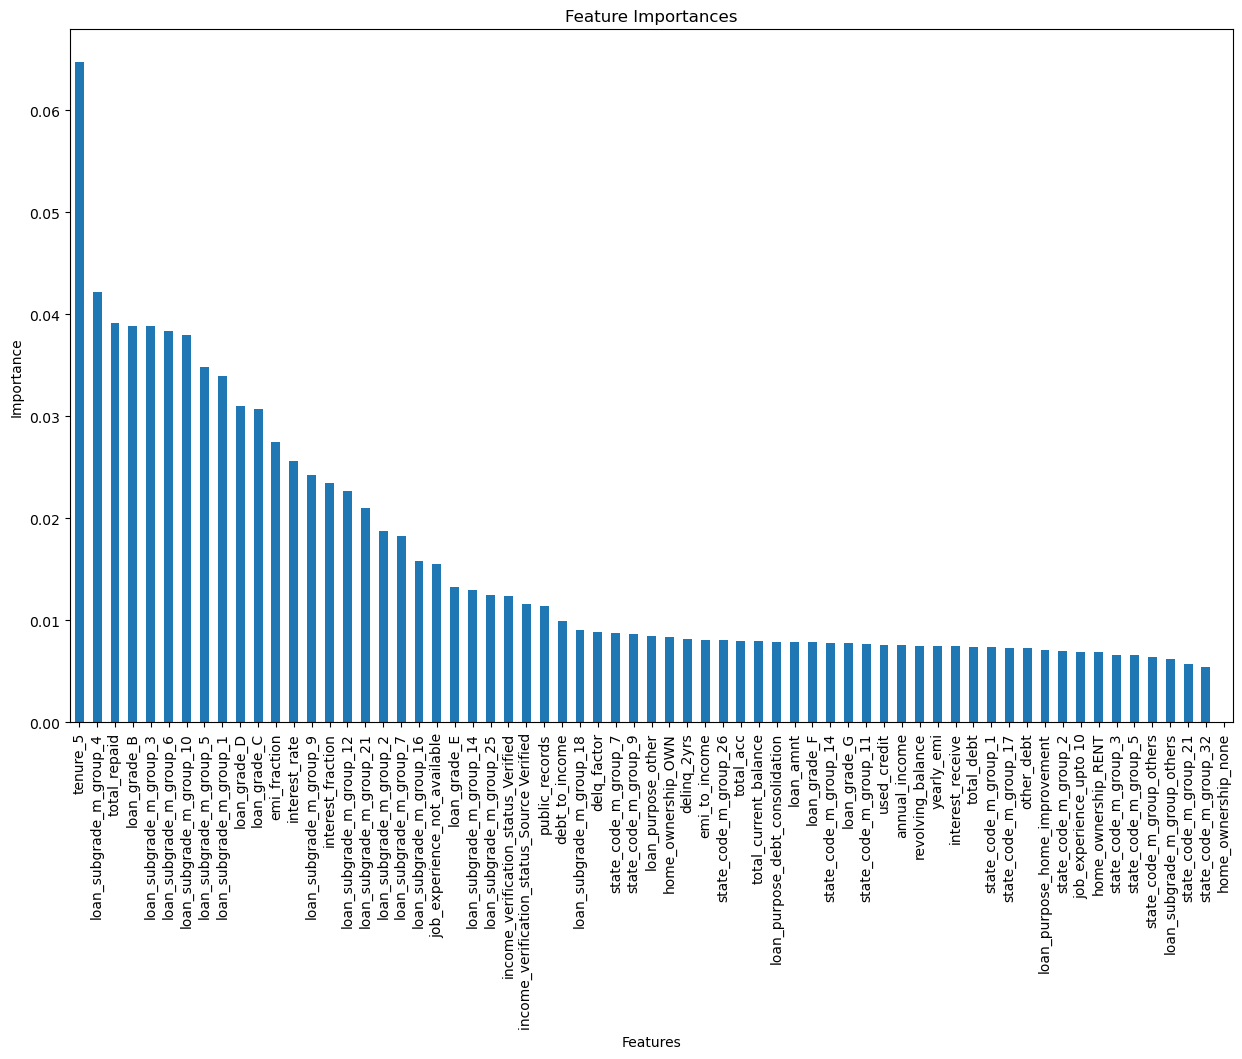

In [139]:
plot_feature_importances(model, final_features)

In [132]:
from sklearn.metrics import accuracy_score

In [133]:
final_pred2 = model.predict(transformed_df_test)

In [143]:
accuracy_score(y, model.predict(X))

0.9286281580698478

In [144]:
final_model2 = pd.DataFrame()
final_model2['ID'] = test_df['ID'].values.tolist()
final_model2['default'] = final_pred2
final_model2.set_index('ID')
final_model2.to_csv('12th_attempt.csv', index = False)

In [ ]:
# import pandas for data wrangling
import pandas as pd


# import numpy for Scientific computations
import numpy as np


# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 258,
        'seed': 0
    }

#hyperopt

In [ ]:
def objective(space):
    clf1=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf1.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf1.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [ ]:
best_hyperparams

{'colsample_bytree': 0.503398020221425,
 'gamma': 1.032694812542812,
 'max_depth': 4.0,
 'min_child_weight': 1.0,
 'reg_alpha': 41.0,
 'reg_lambda': 0.6498016436296549}

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)